<h2 align=center>Generation Of Synthetic Images With DCGANs In Keras From Fashion MNIST Dataset</h2>

## Importing Necessary Libraries

In [24]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


## Loading and Preprocessing the Data

In [25]:
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0


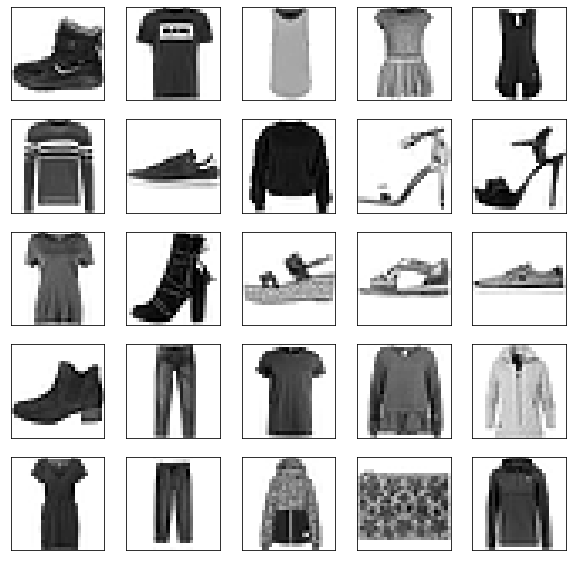

In [26]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Creation Of Batches Of Training Data

In [27]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

## Building The Generator Network For DCGAN

<h1>GAN</h1>

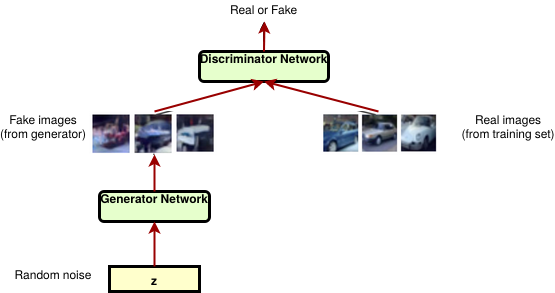

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture For Stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

In [28]:
num_features=100
generator=keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape=[num_features]),
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128,(5,5),(2,2),padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2), padding='same',activation='tanh')
])

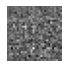

In [29]:
noise=tf.random.normal(shape=[1, num_features])
generated_image=generator(noise, training=False)
plot_utils.show(generated_image, 1)

## Building The Discriminator Network For DCGAN

In [30]:
discriminator=keras.models.Sequential([
    keras.layers.Conv2D(128,(5,5),(2,2), padding='same',input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(512,(5,5),(2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.5009089]], shape=(1, 1), dtype=float32)


## Compiling The Deep Convolutional Generative Adversarial Network (DCGAN)

In [32]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan=keras.models.Sequential([
    generator, discriminator
])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')


## Defining Training Procedure

In [33]:
seed=tf.random.normal(shape=[batch_size,100])

In [34]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator=gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1,epochs))
        for X_batch in dataset:
            noise=tf.random.normal(shape=[batch_size, num_features])
            generated_images=generator(noise)
            X_fake_and_real=tf.concat([generated_images, X_batch], axis=0)
            y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2=tf.constant([[1.]]*batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [35]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training DCGAN

In [36]:
x_train_dcgan=x_train.reshape(-1,28,28,1)*2. -1

In [37]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

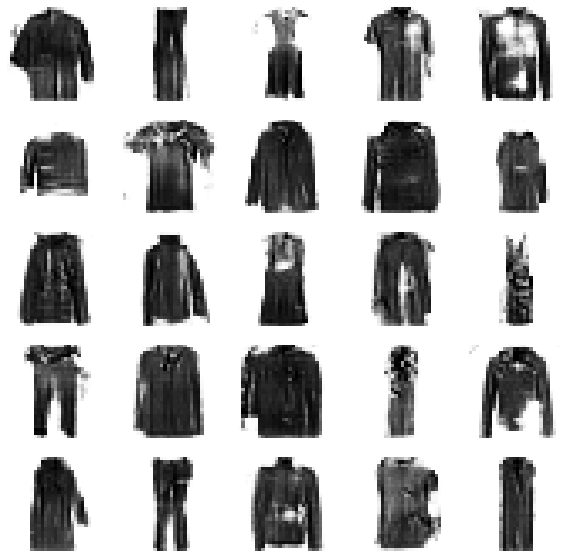

CPU times: user 26min 8s, sys: 2min 14s, total: 28min 22s
Wall time: 51min 56s


In [38]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

## Generating Synthetic Images With DCGAN

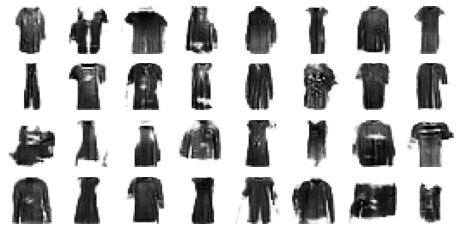

In [39]:
noise=tf.random.normal(shape=[batch_size, num_features])
generated_images=generator(noise)
plot_utils.show(generated_images, 8)

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)